# Yale Hackathon

## 1b

### Section 1: Read pickle file and output array

In [12]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import dynamiqs as dq

# read given input .pickle file 
# function 1
def read_pickle(file_path):
    try:
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            return data
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

# function 1.5
def load_data_from_pickle(file_path): # MUST BE USED IMMEDIATELY AFTER READ_PICKLE, the only thing we care about is Z
    if os.path.exists(file_path):
        data = read_pickle(file_path)
        Z = data[2]
        print(f"Z: {Z}")
        return Z


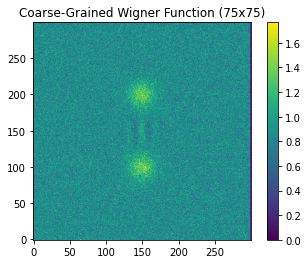

In [38]:
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

# Load the pickle file and extract the third element
data = read_pickle("data\\synthetic\\noisy_wigner_2.pickle")[2]

# Target shape: 75 x 75
scale = 0.3
zoom_factors = (scale, scale)
data_rescaled = zoom(data, zoom_factors)

# Plot the result
plt.imshow(data_rescaled, cmap='viridis', origin='lower')
plt.title("Coarse-Grained Wigner Function (75x75)")
plt.colorbar()
plt.show()


In [39]:
W1= data_rescaled

In [73]:
import numpy as np
import math
from scipy.special import eval_genlaguerre
from scipy.linalg import eigh

def fock_wigner_array(n, m, grid_size=100, x_range=(-5, 5), p_range=(-5, 5), hbar=1):
    """
    Generate Wigner function for |n><m| on a square grid.
    Args:
        n, m: Fock state indices
        grid_size: Points per axis
        x_range, p_range: Quadrature grid bounds
        hbar: Scaling factor (default 1)
    Returns:
        W_nm: 2D array of W_{|n><m|}(x, p)
        x_grid, p_grid: 1D quadrature grids
    """
    x = np.linspace(x_range[0], x_range[1], grid_size)
    p = np.linspace(p_range[0], p_range[1], grid_size)
    X, P = np.meshgrid(x, p, indexing='ij')
    
    r_squared = (X**2 + P**2) / hbar
    phase = (X + 1j*P)**(m - n) if m >= n else (X - 1j*P)**(n - m)
    L = eval_genlaguerre(min(n, m), abs(m - n), 2 * r_squared)
    prefactor = (-1)**min(n, m) * np.sqrt(math.factorial(min(n, m)) / math.factorial(max(n, m)))
    
    W_nm = (prefactor * phase * np.exp(-r_squared) * L / (np.pi * hbar)).astype(complex)
    return W_nm, x, p

def monte_carlo_overlap(W_data, W_nm, x_grid, p_grid, n_samples=1000000):
    """Compute overlap integral using Monte Carlo sampling."""
    indices = np.random.choice(len(x_grid) * len(p_grid), size=n_samples, replace=True)
    integrand = (W_data.flatten()[indices] * W_nm.flatten()[indices])
    area = (x_grid[-1] - x_grid[0]) * (p_grid[-1] - p_grid[0])
    return 2 * np.pi * area * np.mean(integrand)

def reconstruct_density_matrix(W_data, x_grid, p_grid, n_max, n_samples=1000000):
    """Reconstruct ρ_{nm} via Monte Carlo overlaps."""
    dim = n_max + 1
    rho = np.zeros((dim, dim), dtype=complex)
    
    for n in range(dim):
        for m in range(dim):
            W_nm, _, _ = fock_wigner_array(n, m, grid_size=len(x_grid), 
                                         x_range=(x_grid[0], x_grid[-1]), 
                                         p_range=(p_grid[0], p_grid[-1]))
            rho[n, m] = monte_carlo_overlap(W_data, W_nm, x_grid, p_grid, n_samples)
    return rho

def make_physical(rho):
    """Enforce Hermiticity, positivity, and trace=1."""
    rho = (rho + rho.conj().T) / 2  # Force Hermiticity
    evals, evecs = eigh(rho)        # Diagonalize
    evals = np.maximum(evals, 0)    # Clip negative eigenvalues
    rho = evecs @ np.diag(evals) @ evecs.T.conj()
    return rho / np.trace(rho)      # Normalize trace

# Example usage
x = np.linspace(-5, 5, 100)  # Match your experimental grid
p = np.linspace(-5, 5, 100)
X, P = np.meshgrid(x, p, indexing='ij')

# Reconstruct and physicalize
n_max = 30  # Truncate Fock space
rho = reconstruct_density_matrix(W1, x, p, n_max, n_samples=1000000)
rho_physical = make_physical(rho)

print("Reconstructed ρ (raw):\n", np.round(rho, 4))
print("\nPhysical ρ:\n", np.round(rho_physical, 4))
print("\nTrace:", np.trace(rho_physical).real)
print("Eigenvalues:", np.linalg.eigvalsh(rho_physical))

Reconstructed ρ (raw):
 [[ 5.2946e+00+0.j      5.1000e-03-0.0028j  9.2000e-03+0.0186j
   5.0000e-03-0.0114j -5.3000e-03-0.014j  -1.8000e-03-0.0066j
   3.6000e-03+0.0078j -5.0000e-04-0.0062j -1.4000e-03+0.0012j
  -2.7000e-03-0.0012j  3.0000e-04+0.0015j -2.0000e-04-0.0018j
   2.0000e-04-0.0004j -2.0000e-04+0.0003j -1.0000e-04-0.0006j
  -5.0000e-04-0.0002j -1.0000e-04-0.0003j -1.0000e-04-0.j
  -0.0000e+00+0.0001j -0.0000e+00+0.j     -0.0000e+00+0.j
   0.0000e+00-0.j     -0.0000e+00+0.j      0.0000e+00-0.j
   0.0000e+00-0.j     -0.0000e+00-0.j     -0.0000e+00-0.j
   0.0000e+00+0.j      0.0000e+00-0.j      0.0000e+00+0.j
  -0.0000e+00-0.j    ]
 [-1.3300e-02+0.0007j  5.2718e+00+0.j     -1.6000e-03+0.0385j
   2.0500e-02+0.0043j -1.5000e-03-0.0009j  7.0000e-03-0.0008j
  -1.0100e-02-0.0081j  7.2000e-03+0.0003j  1.8000e-03-0.0031j
  -1.3000e-03-0.0015j -4.0000e-04-0.0002j  1.1000e-03+0.001j
  -3.0000e-04-0.0001j -2.0000e-04-0.0005j -0.0000e+00-0.j
   2.0000e-04-0.0001j  1.0000e-04-0.0003j -2.000